In [1]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from scipy.ndimage import gaussian_filter

from numba import njit

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [3]:
sn = read_snap(300, 1, lvl='lvl2', parttype=None, fields=None)

In [78]:
sn2 = read_snap(150, 1, lvl='lvl2', parttype=[0], fields=None)

In [4]:
center = np.array([200., 200., 200.])
gas_pos = sn.part0.pos.value - center

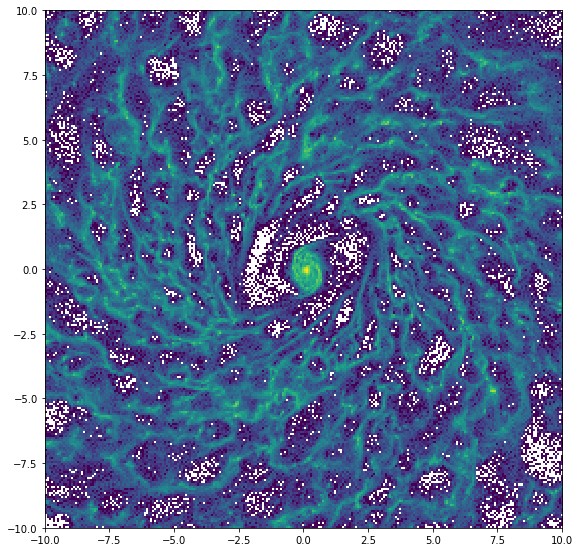

In [6]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = gas_pos[:,0]
y = gas_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


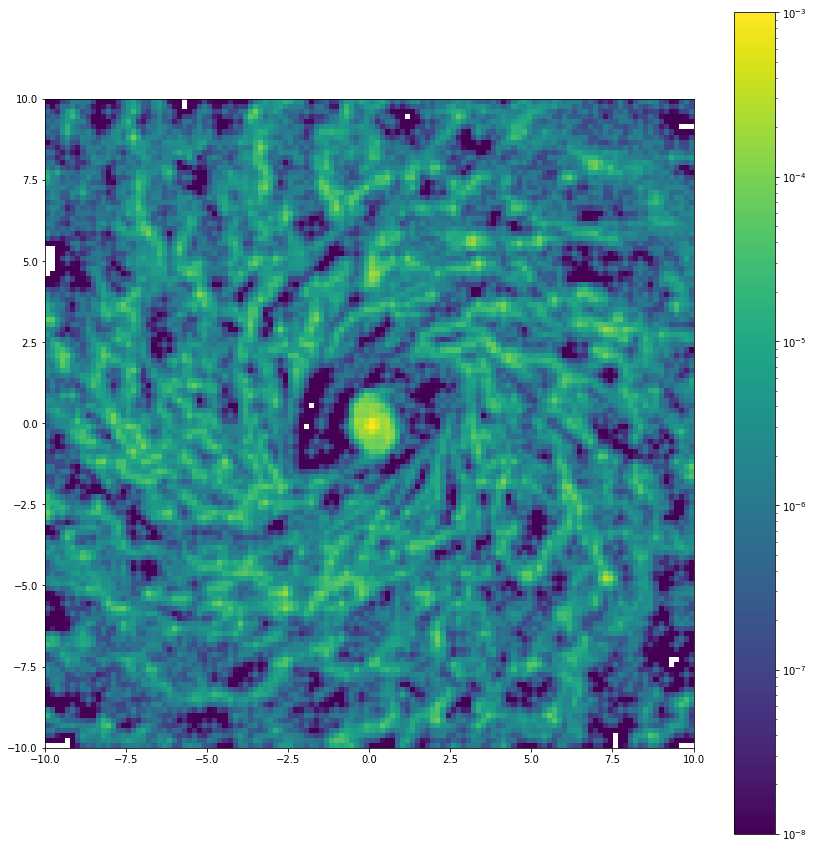

In [19]:
XH2 = sn.part0.MolecularHFrac

nres = 128

range_xy = [[-10, 10], [-10, 10]]

x = gas_pos[:,0]
y = gas_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=sn.part0.mass.value*XH2)

heatmap_xy = gaussian_filter(heatmap_xy, 0.5)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(vmin=1E-8, vmax=1E-3))
ax.set_aspect('equal')
fig.tight_layout()
fig.colorbar(im, ax=ax)

plt.show()


In [26]:
sn700 = read_snap(160, 1, lvl='lvl3-snap700', parttype=None, fields=None)

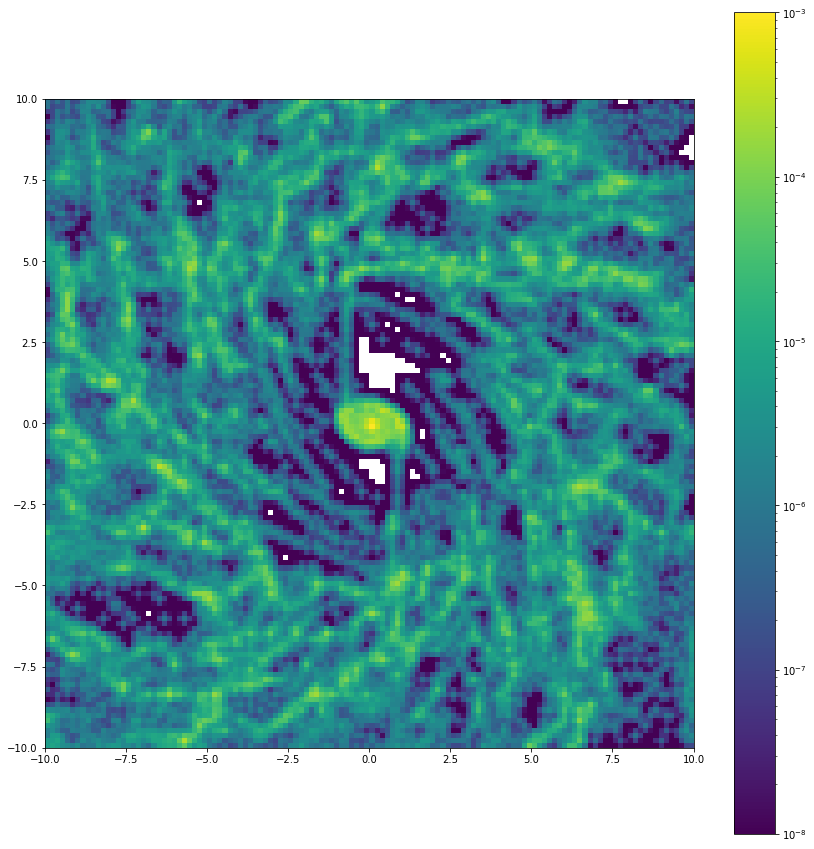

In [27]:
XH2 = sn700.part0.MolecularHFrac

gas_pos700 = sn700.part0.pos.value - center

nres = 128

range_xy = [[-10, 10], [-10, 10]]

x = gas_pos700[:,0]
y = gas_pos700[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=sn700.part0.mass.value*XH2)

heatmap_xy = gaussian_filter(heatmap_xy, 0.5)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(vmin=1E-8, vmax=1E-3))
ax.set_aspect('equal')
fig.tight_layout()
fig.colorbar(im, ax=ax)

plt.show()


In [28]:
def compute_inflow(sn, Rmin = 3.0, Rmax=4.0, center=np.array([200., 200., 200.])):
    gas_pos = sn.part0.pos.value - center
    gas_vel = sn.part0.vel.value
    gas_mass = sn.part0.mass.value
    
    R = np.linalg.norm(gas_pos[:,:2], axis=1)
    ctheta = gas_pos[:,0]/R
    stheta = gas_pos[:,1]/R
    
    vR = ctheta * gas_vel[:,0] + stheta * gas_vel[:,1]
    
    vR *= gas_mass
    key = np.logical_and(R > Rmin, R < Rmax)
    return np.sum(vR[key] / (Rmax - Rmin))
    

In [29]:
compute_inflow(sn700)

-0.0961393164787875

In [30]:
compute_inflow(sn)

0.05088951609846854

In [32]:
key = np.linalg.norm(sn700.part0.pos.value - center, axis=1) < 2.3
print(np.sum(sn700.part0.mass.value[key]))

0.031404037


In [34]:
idx_list = np.array([200, 201, 202, 203, 204, 205])
for idx in idx_list:
    _sn = read_snap(idx, 1, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'])
    print(compute_inflow(_sn))

-0.05809839070119928
-0.11343848031316779
-0.14687511021977645
-0.08601914890250131
0.015309864173653827
0.05859146822238212


In [45]:
from scipy.stats import binned_statistic_2d

In [69]:
XH2 = sn.part0.MolecularHFrac

gas_pos = sn.part0.pos.value - center

nres = 128

range_xy = [[-10, 10], [-10, 10]]

x = gas_pos[:,0]
y = gas_pos[:,1]
vz = sn.part0.vel.value[:,2]
mass = sn.part0.mass.value

mean_mass, _, _, _ = binned_statistic_2d(x, y, XH2*mass, statistic='sum', range=range_xy, bins=(nres, nres))

# mean_vz, _, _, _ = binned_statistic_2d(x, y, XH2*mass*vz, statistic = 'sum', )
# mean_vz /= mean_mass



mean_vz, _, _, _ = binned_statistic_2d(x, y, XH2*mass*vz, statistic='sum', range=range_xy, bins=(nres, nres))
mean_vz2, _, _, _ = binned_statistic_2d(x, y, (XH2*mass*vz)**2., statistic='sum', range=range_xy, bins=(nres, nres))

sigma_vz = np.sqrt(mean_vz2 - mean_vz**2)

sigma_vz /= mean_mass

# sigma_vz, _, _, _ = binned_statistic_2d(x, y, vz, statistic='std', range=range_xy, bins=(nres, nres))





/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


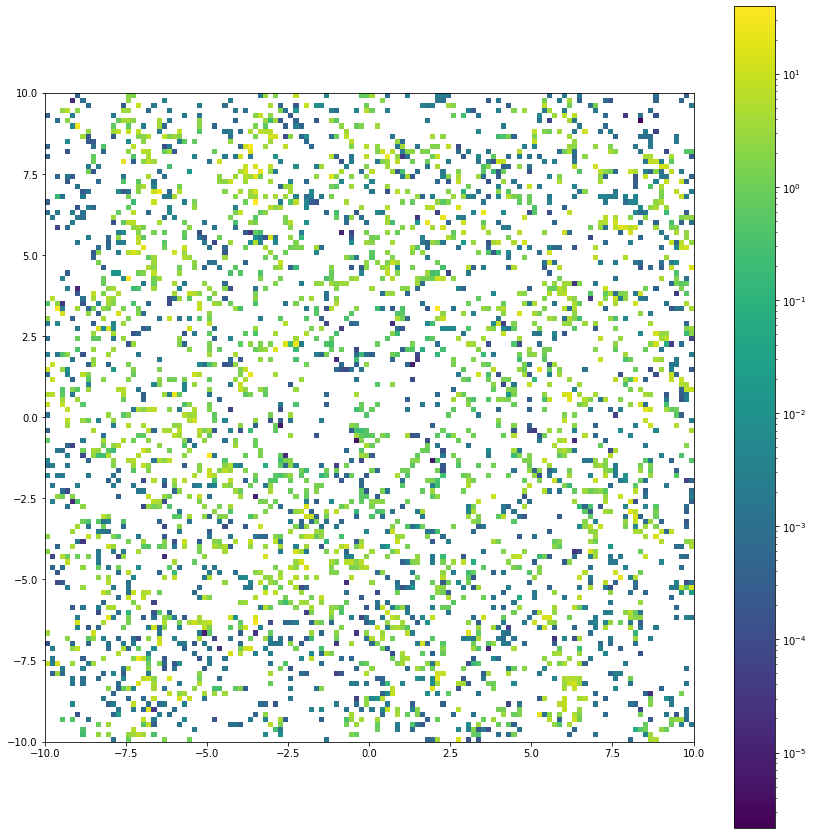

In [70]:
extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(sigma_vz.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()
fig.colorbar(im, ax=ax)

plt.show()

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


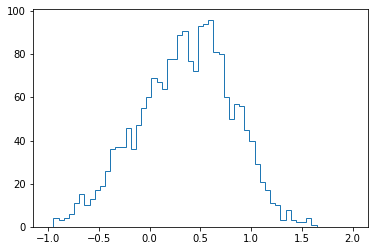

In [76]:
plt.hist(np.log10(sigma_vz.ravel()), bins=np.linspace(-1, np.log10(100), 60), histtype='step')
plt.show()

In [52]:
sigma_vz.s

(128, 128)

In [118]:
XH2 = sn2.part0.MolecularHFrac

gas_pos = sn2.part0.pos.value - center

nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = gas_pos[:,0]
y = gas_pos[:,1]
vz = sn2.part0.vel.value[:,2]
mass = sn2.part0.mass.value

mean_mass, _, _, _ = binned_statistic_2d(x, y, XH2*mass, statistic='sum', range=range_xy, bins=(nres, nres))
mean_vz, _, _, _ = binned_statistic_2d(x, y, XH2*mass*vz, statistic='sum', range=range_xy, bins=(nres, nres))

mean_vz /= mean_mass

mean_vz, _, _, _ = binned_statistic_2d(x, y, XH2*mass*vz - mean_vz, statistic='sum', range=range_xy, bins=(nres, nres))

mean_vz[mean_mass == 0.0] = 0.0
mean_vz2[mean_mass == 0.0] = 0.0

sigma_vz = np.sqrt(mean_vz2 - mean_vz**2)

# sigma_vz /= mean_mass

# sigma_vz, _, _, _ = binned_statistic_2d(x, y, vz, statistic='std', range=range_xy, bins=(nres, nres))





/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


In [121]:
np.where(np.isnan(sigma_vz))

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([  6,  63,  74, ..., 193, 201, 212]))

In [122]:
(mean_vz2 - mean_vz)[mean_vz2 - mean_vz < 0]

array([-0.10256835, -0.23924615, -0.24313379, -0.12239157, -0.1694    ,
       -0.21468935, -0.13769922, -0.11633571, -0.02065931, -0.13624213,
       -0.21078993, -0.10997826, -0.11688255, -0.23987524, -0.15841667,
       -0.21652036, -0.16097315, -0.24213183, -0.11107577, -0.22712581,
       -0.05775483, -0.1427019 , -0.11807075, -0.22678571, -0.24847935,
       -0.23039826, -0.20081019, -0.24578076, -0.24397931, -0.16994562,
       -0.16277033, -0.23011888, -0.11159489, -0.22871391, -0.02155158,
       -0.07728997, -0.19949579, -0.13639248, -0.00844361, -0.08006646,
       -0.24529592, -0.13463355, -0.23247501, -0.11045795, -0.05860207,
       -0.24680281, -0.14135095, -0.2117061 , -0.17341976, -0.1874285 ,
       -0.23237641, -0.24482096, -0.19319804, -0.08043658, -0.24911051,
       -0.21345265, -0.01591913, -0.24391167, -0.24600779, -0.24838965,
       -0.24112498, -0.21807812, -0.21891413, -0.22407112, -0.13057299,
       -0.18215341, -0.2177983 , -0.15033814, -0.00752228, -0.02

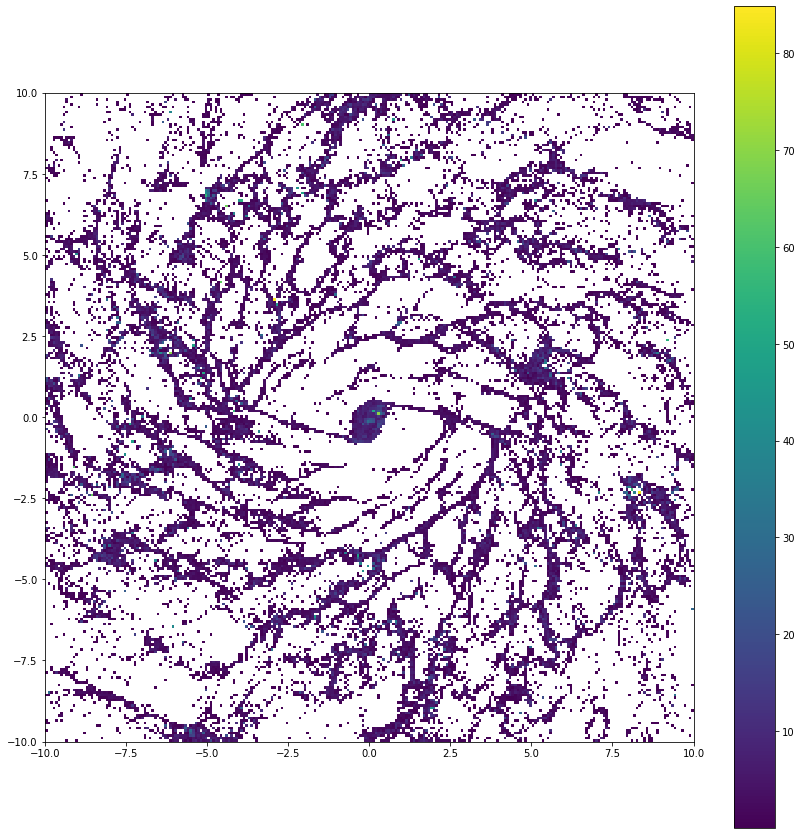

In [111]:
extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(sigma_vz.T, extent=extent, origin='lower')#, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()
fig.colorbar(im, ax=ax)

plt.show()

In [112]:
np.where((mean_vz2 - mean_vz**2) < 0)

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([  6,  63,  74, ..., 193, 201, 212]))

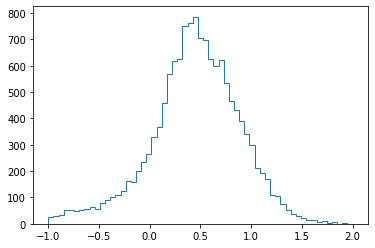

In [110]:
plt.hist(np.log10(sigma_vz.ravel()), bins=np.linspace(-1, np.log10(100), 60), histtype='step')
plt.show()

In [86]:
XH2 = sn700.part0.MolecularHFrac

gas_pos = sn700.part0.pos.value - center

nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = gas_pos[:,0]
y = gas_pos[:,1]
vz = sn700.part0.vel.value[:,2]
mass = sn700.part0.mass.value

mean_mass, _, _, _ = binned_statistic_2d(x, y, XH2*mass, statistic='sum', range=range_xy, bins=(nres, nres))

# mean_vz, _, _, _ = binned_statistic_2d(x, y, XH2*mass*vz, statistic = 'sum', )
# mean_vz /= mean_mass



mean_vz, _, _, _ = binned_statistic_2d(x, y, XH2*mass*vz, statistic='sum', range=range_xy, bins=(nres, nres))
mean_vz2, _, _, _ = binned_statistic_2d(x, y, (XH2*mass*vz)**2., statistic='sum', range=range_xy, bins=(nres, nres))

sigma_vz = np.sqrt(mean_vz2 - mean_vz**2)

sigma_vz /= mean_mass

# sigma_vz, _, _, _ = binned_statistic_2d(x, y, vz, statistic='std', range=range_xy, bins=(nres, nres))





/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


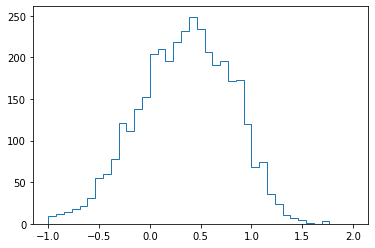

In [87]:
plt.hist(np.log10(sigma_vz.ravel()), bins=np.linspace(-1, np.log10(100), 40), histtype='step')
plt.show()

## Second Try

Just trying to compute the mass-weighted standard deviation.

In [ ]:
sn = read_snap(300, 1, lvl='lvl2', parttype=None, fields=None)

In [ ]:
center = np.array([200., 200., 200.])
pos = sn.part0.pos.value - center
vel = sn.part0.vel.value
mass = sn.part0.mass.value * sn.part0.MolecularHFrac

In [ ]:
nres = 128
rng = [-10, 10]

bins = np.linspace(rng[0], rng[1], nres+1)

key = np.logical_and(np.abs(pos[:,0]) < bins[-1], np.abs(pos[:,1])< bins[-1])

pos_in_rng = pos[key]
vel_in_rng = vel[key]
mass_in_rng = mass[key]

xbins = np.digitize(pos_in_rng[:,0], bins)
ybins = np.digitize(pos_in_rng[:,1], bins)


In [ ]:
std_vz = np.zeros((nres, nres))
ave_R = np.zeros((nres, nres))

R = np.linalg.norm(pos_in_rng[:,:2], axis=1)

for i in tqdm(range(nres)):
    for j in range(nres):
        in_bin = np.where(np.logical_and(xbins==i, ybins==j))[0]
        if len(in_bin)<9:
            std_vz[i][j] = np.nan
        else:
            N = len(in_bin)
            vz = vel_in_rng[:,2][in_bin]
            m = mass_in_rng[in_bin]
            mean_vz = np.sum(m * vz) / np.sum(m)
            
            this_std = np.sum(m * (vz - mean_vz)**2) / np.sum(m)
            this_std *= N/(N-1)
            std_vz[i][j] = this_std
            
            ave_R[i][j] = np.mean(R[in_bin])
            

A Jupyter Widget

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in float_scalars
  from ipykernel import kernelapp as app


In [ ]:
ave_R

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 13.70775812,
        13.79046083,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 13.58909879,
        13.71220049,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

0.2476806640625


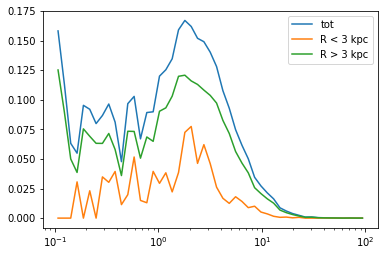

In [ ]:
hist_bins = np.logspace(-1, 2, 50)

plot_bins = (hist_bins[:-1] + hist_bins[1:])/2.0

hist0, _ = np.histogram(np.sqrt(std_vz).ravel(), bins=hist_bins, density=True)
hist1, _ = np.histogram(np.sqrt(std_vz).ravel()[ave_R.ravel() < 3], bins=hist_bins, density=True)
hist2, _ = np.histogram(np.sqrt(std_vz).ravel()[ave_R.ravel() >= 3], bins=hist_bins, density=True)

frac = len(np.where(ave_R.ravel() < 3)[0]) / len(ave_R.ravel())

print(frac)

plt.plot(plot_bins, hist0, label='tot')
plt.plot(plot_bins, frac*hist1, label='R < 3 kpc')
plt.plot(plot_bins, (1-frac)*hist2, label='R > 3 kpc')

plt.legend()

# plt.hist(np.sqrt(std_vz).ravel(), bins=np.logspace(-1, 2, 100), density=True)
# plt.hist(np.sqrt(std_vz).ravel()[ave_R.ravel() < 2], bins=np.logspace(-1, 2, 100), density=True)
plt.xscale('log')
plt.show()

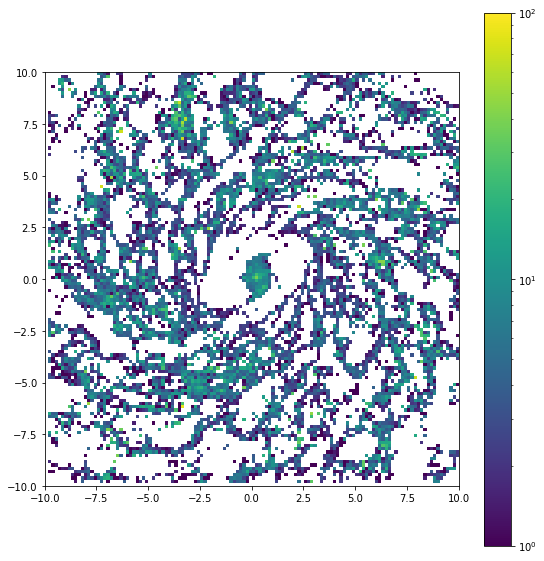

In [ ]:
range_xy = [[-10, 10], [-10, 10]]

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

heatmap = np.sqrt(std_vz)

im = ax.imshow(heatmap.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(vmin=1, vmax=100))
ax.set_aspect('equal')
fig.tight_layout()

fig.colorbar(im, ax=ax)

plt.show()
